In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from joblib import Parallel, delayed
import pandas as pd
import time

# Constants
a1, a2, a3, a4, a5, a6, a7, a8, a9 = 23.8, 5.6, 4.8, 4.4, 4.1, 3.8, 3.4, 2.7, 1.8
k1, k2, k3, k4, k5, k6, k7, k8, k9 = 0.1, 0.09, 0.07, 0.04, 0.01, 0.009, 0.006, 0.003, 0.002
N = 200     
b_min = 5e-4
b_max = 0.1
b_vals = np.logspace(np.log10(b_min), np.log10(b_max), N)

In [2]:
from scipy.special import logsumexp
def softmax_partition_MM10(u):
    u1, u2, u3, u4, u5, u6, u7, u8, u9 = u
    logZ = logsumexp([u1, u2, u3, u4, u5, u6, u7, u8, u9, 0.0])
    theta1 = np.exp(u1 - logZ)
    theta2 = np.exp(u2 - logZ)
    theta3 = np.exp(u3 - logZ)
    theta4 = np.exp(u4 - logZ)
    theta5 = np.exp(u5 - logZ)
    theta6 = np.exp(u6 - logZ)
    theta7 = np.exp(u7 - logZ)
    theta8 = np.exp(u8 - logZ)
    theta9 = np.exp(u9 - logZ)
    theta10 = np.exp(-logZ)
    return theta1, theta2, theta3, theta4, theta5, theta6, theta7, theta8, theta9, theta10

# System
def BioSystemMM10(theta, b_val):
    term_Y1 = (a1 * theta[1]) / (b_val * theta[0]) + k1 - 1
    Y1 = (1/2) * (np.sqrt(term_Y1**2 + 4 * k1) - term_Y1)
    term_Y2 = (a2 * theta[2]) / (b_val * theta[0]) + k2 - (1 - Y1)
    Y2 = (1/2) * (np.sqrt(term_Y2**2 + 4 * (1 - Y1) * k2) - term_Y2)
    term_Y3 = (a3 * theta[3]) / (b_val * theta[0]) + k3 - (1 - Y1 - Y2)
    Y3 = (1/2) * (np.sqrt(term_Y3**2 + 4 * (1 - Y1 - Y2) * k3) - term_Y3)
    term_Y4 = (a4 * theta[4]) / (b_val * theta[0]) + k4 - (1 - Y1 - Y2 - Y3)
    Y4 = (1/2) * (np.sqrt(term_Y4**2 + 4 * (1 - Y1 - Y2 - Y3) * k4) - term_Y4)
    term_Y5 = (a5 * theta[5]) / (b_val * theta[0]) + k5 - (1 - Y1 - Y2 - Y3 - Y4)
    Y5 = (1/2) * (np.sqrt(term_Y5**2 + 4 * (1 - Y1 - Y2 - Y3 - Y4) * k5) - term_Y5)
    term_Y6 = (a6 * theta[6]) / (b_val * theta[0]) + k6 - (1 - Y1 - Y2 - Y3 - Y4 - Y5)
    Y6 = (1/2) * (np.sqrt(term_Y6**2 + 4 * (1 - Y1 - Y2 - Y3 - Y4 - Y5) * k6) - term_Y6)
    term_Y7 = (a7 * theta[7]) / (b_val * theta[0]) + k7 - (1 - Y1 - Y2 - Y3 - Y4 - Y5 - Y6)
    Y7 = (1/2) * (np.sqrt(term_Y7**2 + 4 * (1 - Y1 - Y2 - Y3 - Y4 - Y5 - Y6) * k7) - term_Y7)
    term_Y8 = (a8 * theta[8]) / (b_val * theta[0]) + k8 - (1 - Y1 - Y2 - Y3 - Y4 - Y5 - Y6 - Y7)
    Y8 = (1/2) * (np.sqrt(term_Y8**2 + 4 * (1 - Y1 - Y2 - Y3 - Y4 - Y5 - Y6 - Y7) * k8) - term_Y8)
    term_Y9 = (a9 * theta[9]) / (b_val * theta[0]) + k9 - (1 - Y1 - Y2 - Y3 - Y4 - Y5 - Y6 - Y7 - Y8)
    Y9 = (1/2) * (np.sqrt(term_Y9**2 + 4 * (1 - Y1 - Y2 - Y3 - Y4 - Y5 - Y6 - Y7 - Y8) * k9) - term_Y9)
    Y10 = (a9 * theta[9] / b_val) * (Y9 / (k9 + Y9))
    Y11 = (theta[1] / theta[0]) * Y10
    Y12 = (theta[2] / theta[0]) * Y10
    Y13 = (theta[3] / theta[0]) * Y10
    Y14 = (theta[4] / theta[0]) * Y10
    Y15 = (theta[5] / theta[0]) * Y10
    Y16 = (theta[6] / theta[0]) * Y10
    Y17 = (theta[7] / theta[0]) * Y10
    Y18 = (theta[8] / theta[0]) * Y10
    Y19 = (theta[9] / theta[0]) * Y10
    lambda_val = b_val * Y10
    r_denom = (k1 + Y1)/(a1*Y11) + (k2+Y2)/(a2*Y12) + (k3+Y3)/(a3*Y13) + (k4+Y4)/(a4*Y14) + (k5+Y5)/(a5*Y15) + (k6+Y6)/(a6*Y16) + (k7+Y7)/(a7*Y17) + (k8+Y8)/(a8*Y18) + (k9+Y9)/(a9*Y19)
    r_avg = 1 / r_denom if r_denom != 0 else np.nan
    return np.array([b_val, theta[0], theta[1], theta[2], theta[3], theta[4], theta[5], theta[6], theta[7], theta[8], theta[9],
                     Y1, Y2, Y3, Y4, Y5, Y6, Y7, Y8, Y9, Y10, Y11, Y12, Y13, Y14, Y15, Y16, Y17, Y18, Y19, lambda_val, r_avg])

def objective_softmax(u, b_val): 
    try: return -BioSystemMM10(softmax_partition_MM10(u), b_val)[30]
    except: return np.inf

def optimize_for_b_softmax(b_val, tol=1e-7, gtol=1e-8, maxiter=1000):
    result = minimize(
        lambda u: objective_softmax(u, b_val),
        x0=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # Fixed: 9 initial values for 9 u parameters
        method='BFGS',
        tol=tol,                       # global tolerance
        options={
            'gtol': gtol,              # gradient tolerance
            'maxiter': maxiter,        # maximum iterations
            'disp': False              # Turn off display to reduce output noise
        }
    )
    if result.success: return BioSystemMM10(softmax_partition_MM10(result.x), b_val)
    return None

start = time.time()
results = Parallel(n_jobs=-1)(delayed(optimize_for_b_softmax)(b) for b in b_vals)
results = np.array([r for r in results if r is not None])
print(f"Optimization completed in {time.time() - start:.2f} seconds.")

# Output
(b_arr, theta1_arr, theta2_arr, theta3_arr, theta4_arr, theta5_arr, theta6_arr, theta7_arr, theta8_arr, theta9_arr, theta10_arr,
 Y1_arr, Y2_arr, Y3_arr, Y4_arr, Y5_arr, Y6_arr, Y7_arr, Y8_arr, Y9_arr, Y10_arr, Y11_arr, Y12_arr, Y13_arr, Y14_arr, Y15_arr, 
 Y16_arr, Y17_arr, Y18_arr, Y19_arr, lambda_arr, r_avg_arr) = results.T

Optimization completed in 8.81 seconds.


### Plots

,Nutrient level,Growth rate,Y1,Y2,Y3,Y4,Y5,Y6,Y7,Y8,Y9,Y10,Sum_Y
0,0.002537,0.002372,0.003209,0.006248,0.005913,0.004642,0.002396,0.002355,0.002025,0.001605,0.001602,0.935138,1.0
1,0.003492,0.003225,0.003754,0.007304,0.006904,0.005415,0.002792,0.002743,0.002359,0.001867,0.001863,0.923443,1.0
2,0.003989,0.003662,0.004008,0.007791,0.007362,0.005772,0.002974,0.002921,0.002513,0.001989,0.001984,0.917960,1.0
3,0.004437,0.004053,0.004222,0.008205,0.007749,0.006073,0.003129,0.003072,0.002643,0.002091,0.002084,0.913288,1.0
4,0.004680,0.004263,0.004333,0.008419,0.007951,0.006230,0.003209,0.003151,0.002710,0.002144,0.002136,0.910853,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,0.089898,0.054779,0.017562,0.033410,0.030579,0.023285,0.011742,0.011334,0.009590,0.007469,0.007326,0.609353,1.0
94,0.092323,0.055835,0.017774,0.033799,0.030919,0.023532,0.011862,0.011446,0.009682,0.007539,0.007392,0.604776,1.0
95,0.094814,0.056905,0.017987,0.034193,0.031261,0.023780,0.011983,0.011559,0.009774,0.007608,0.007458,0.600169,1.0
96,0.097373,0.057989,0.018202,0.034590,0.031606,0.024030,0.012104,0.011672,0.009866,0.007678,0.007524,0.595533,1.0


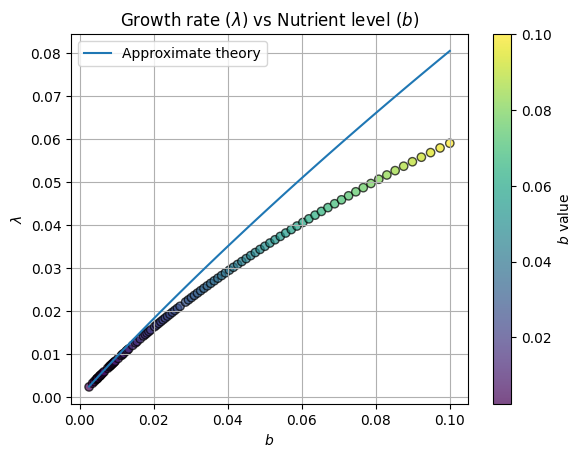

C:\Users\huang\AppData\Local\Temp\ipykernel_20080\630928998.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


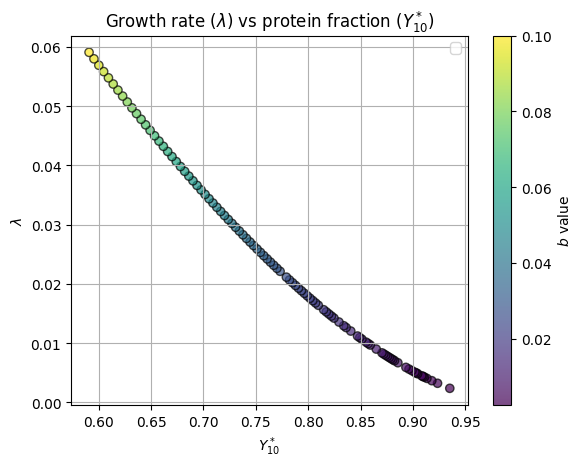

C:\Users\huang\AppData\Local\Temp\ipykernel_20080\630928998.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


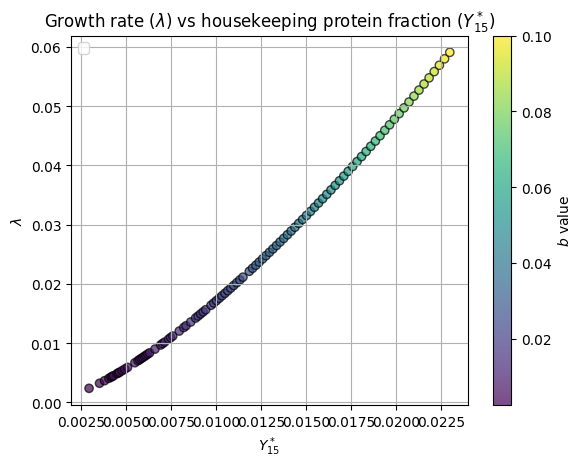

C:\Users\huang\AppData\Local\Temp\ipykernel_20080\630928998.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


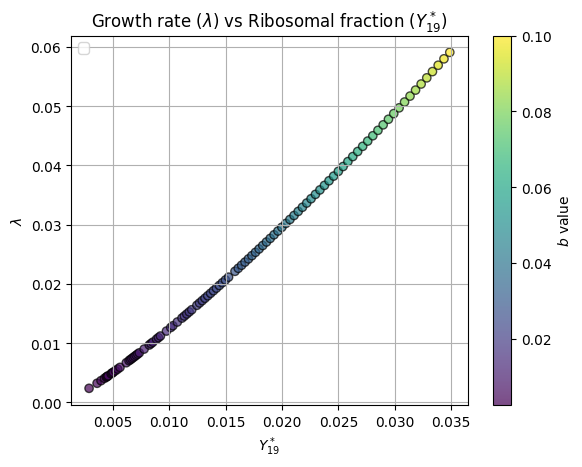

In [3]:
# Put in DataFrame
df = pd.DataFrame({
    "Nutrient level": b_arr,
    "Growth rate": lambda_arr,
    "Y1": Y1_arr,
    "Y2": Y2_arr,
    "Y3": Y3_arr,
    "Y4": Y4_arr,
    "Y5": Y5_arr,
    "Y6": Y6_arr,
    "Y7": Y7_arr,
    "Y8": Y8_arr,
    "Y9": Y9_arr,
    "Y10": Y10_arr,
    "Sum_Y": Y1_arr + Y2_arr + Y3_arr + Y4_arr + Y5_arr + Y6_arr + Y7_arr + Y8_arr + Y9_arr + Y10_arr + Y11_arr + Y12_arr + Y13_arr + Y14_arr + Y15_arr + Y16_arr + Y17_arr + Y18_arr + Y19_arr
})
display(df)

# Growth rate to nutrient level (b)
lambda_approx_arr = b_arr - (np.sqrt(k1/a1) + np.sqrt(k2/a2) + np.sqrt(k3/a3) + np.sqrt(k4/a4) + np.sqrt(k5/a5) 
                             + np.sqrt(k6/a6) + np.sqrt(k7/a7) + np.sqrt(k8/a8) + np.sqrt(k9/a9))*b_arr**(3/2)

plt.figure()
scatter = plt.scatter(b_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.plot(b_arr, lambda_approx_arr, '-', label='Approximate theory')
plt.xlabel(r'$b$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs Nutrient level ($b$)')
plt.legend()
plt.grid(True)
plt.show()

# Growth rate to protein fraction (Y10)
plt.figure()
scatter = plt.scatter(Y10_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$Y_{10}^*$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs protein fraction ($Y_{10}^*$)')
plt.grid(True)
plt.legend()
plt.show()

# Growth rate to protein fraction (Y15) -> this should be constant
plt.figure()
scatter = plt.scatter(Y15_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$Y_{15}^*$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs housekeeping protein fraction ($Y_{15}^*$)')
plt.grid(True)
# plt.xlim(0, 0.01)
plt.legend()
plt.show()

# Growth rate to ribosomal fraction (Y19)
plt.figure()
scatter = plt.scatter(Y19_arr, lambda_arr, c=b_arr, cmap='viridis', edgecolors='k', alpha=0.7)
plt.colorbar(scatter, label=r'$b$ value')
plt.xlabel(r'$Y_{19}^*$'); plt.ylabel(r'$\lambda$')
plt.title(r'Growth rate ($\lambda$) vs Ribosomal fraction ($Y_{19}^*$)')
plt.grid(True)
plt.legend()
plt.show()